# AAPL Stock Price Prediction
**Using LSTM (Long short-term memory) artificial neural network to predict stock price of Apple(AAPL)**

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [14]:
APPL_data = pd.read_csv("data/stock-prediction-data.csv", index_col=0)
APPL_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-11,22.651302,22.671899,22.278242,22.550598,198957600,0.0,0.0
2016-01-12,23.012918,23.044960,22.621548,22.877884,196616800,0.0,0.0
2016-01-13,22.960282,23.159400,22.269094,22.289692,249758400,0.0,0.0
2016-01-14,22.420146,22.996901,21.912054,22.777184,252680400,0.0,0.0
2016-01-15,22.017333,22.362928,21.825083,22.230183,319335600,0.0,0.0
...,...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,63814900,0.0,0.0
2022-12-27,131.380005,131.410004,128.720001,130.029999,69007800,0.0,0.0
2022-12-28,129.669998,131.029999,125.870003,126.040001,85438400,0.0,0.0


In [15]:
APPL_data.index = pd.to_datetime(APPL_data.index)
start_date = APPL_data.index[0]
end_date = APPL_data.index[-1]
print(f"Data of AAPL from {start_date} to {end_date}")

Data of AAPL from 2016-01-11 00:00:00 to 2022-12-30 00:00:00


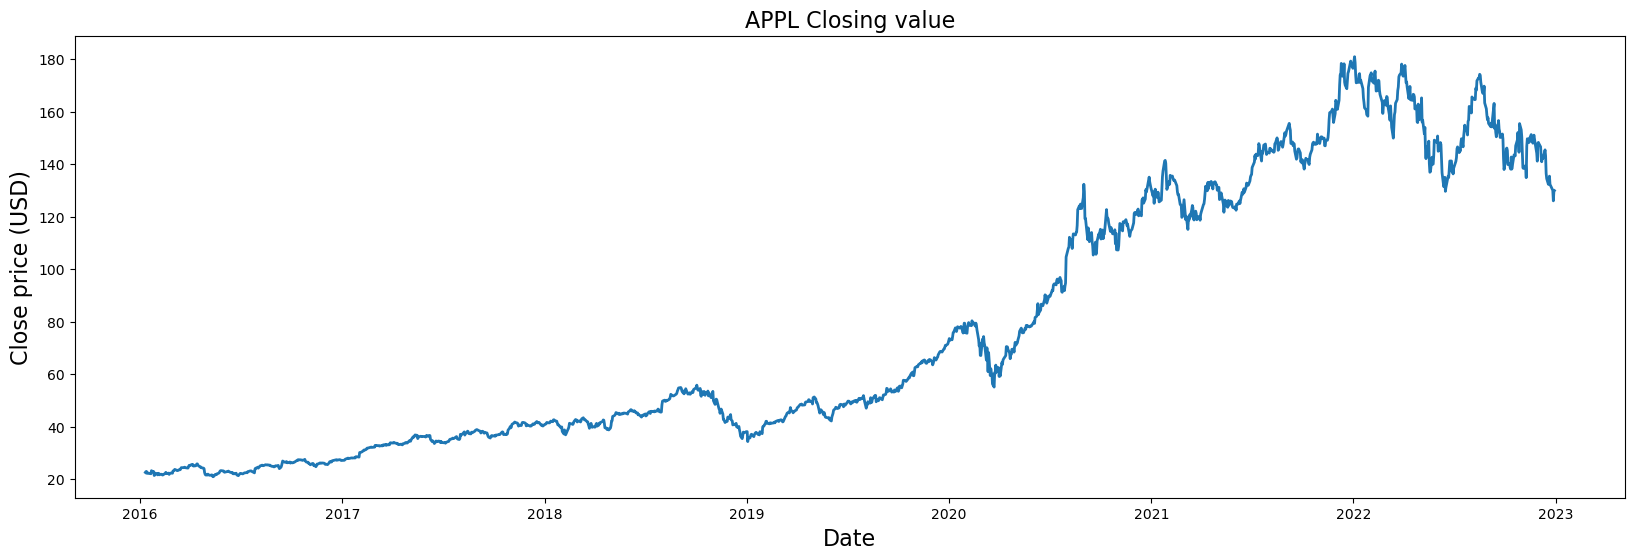

In [16]:
plt.figure(figsize=(20,6))
plt.plot(APPL_data.index, APPL_data['Close'], lw=2)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close price (USD)", fontsize=16)
plt.title("APPL Closing value", fontsize=16);

## Model

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
APPL_data['Close'] = scaler.fit_transform(APPL_data[['Close']])

In [18]:
split_date = pd.to_datetime("2022-01-01").date()
train_data = APPL_data.loc[:split_date]
test_data = APPL_data.loc[split_date:]

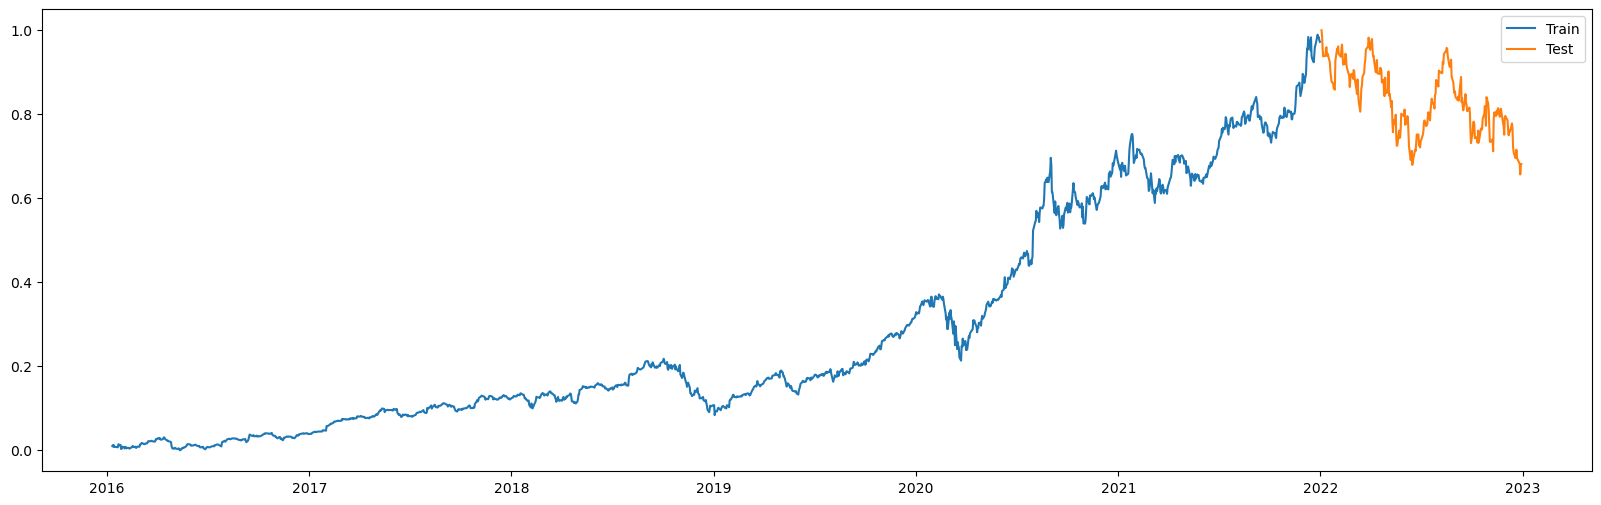

In [19]:
plt.figure(figsize=(20,6))
plt.plot(train_data['Close'])
plt.plot(test_data['Close'])
plt.legend(['Train', 'Test'])
plt.show()

In [20]:
X_train = train_data.index
y_train = train_data['Close']

X_test = test_data.index
y_test = test_data['Close']

n_features = 1

train_series = y_train.values.reshape((len(y_train), n_features))
test_series  = y_test.values.reshape((len(y_test), n_features))

### LSTM Network
Using a `look_back = 24`. This means that we shall be using 24 previous data points (4-weeks) in order to predict the next data point

In [21]:
%%time

from keras.preprocessing.sequence import TimeseriesGenerator

look_back = 24

train_generator = TimeseriesGenerator(train_series, train_series, length=look_back, sampling_rate=1, stride=1, batch_size=10)

test_generator = TimeseriesGenerator(test_series, test_series, length=look_back, sampling_rate=1, stride=1, batch_size=10)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

n_neurons  = 4
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(train_generator,epochs=300, verbose=0)

CPU times: user 5min 58s, sys: 8min 29s, total: 14min 28s
Wall time: 4min 20s


In [22]:
test_predictions  = model.predict(test_generator)

23/23 [==============================] - 0s 2ms/step


### Performance

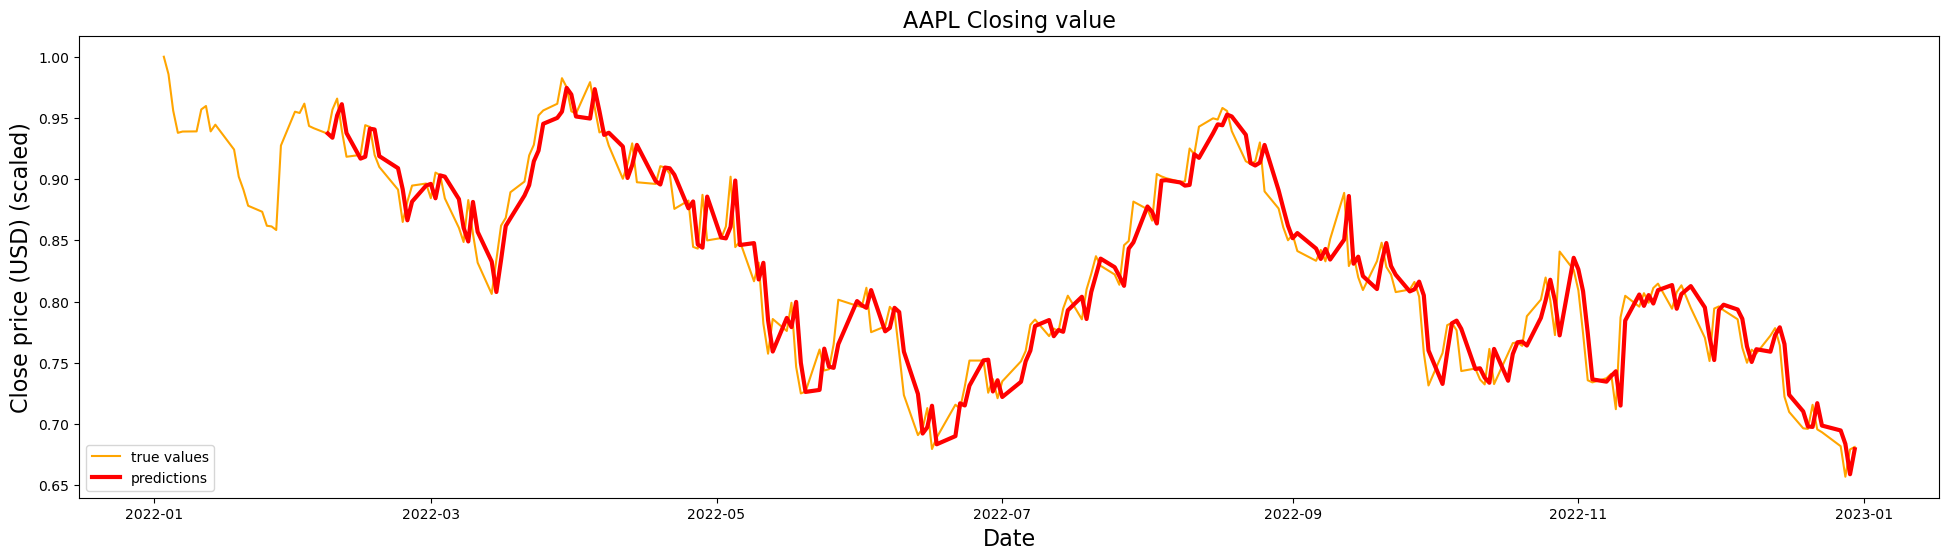

In [23]:
plt.figure(figsize=(look_back,6))
plt.plot(test_data.index, test_data['Close'], c='orange',label='true values')
plt.plot(test_data.index[look_back:],test_predictions, lw=3, c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close price (USD) (scaled)", fontsize=16)
plt.title("AAPL Closing value", fontsize=16);

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

predicted_test_data = test_data[look_back:]
print("LSTM model  MSE: %.4f" % mean_squared_error(predicted_test_data["Close"], test_predictions))
print("LSTM model  MAE: %.4f" % median_absolute_error(predicted_test_data["Close"], test_predictions))

LSTM model  MSE: 0.0005
LSTM model  MAE: 0.0147
